Agatha Justina Majcher  
M.Sc. Renewable Energy Systems

# Distributional Analysis of the Carbon Tax in South Africa

# Analysis of all scenarios

n0 - base IRP 2019 with max 275 MtCo2

n1 - with additional investment add_carbontax_constraint and max 275 MtCO2 - NOT USED!

n2 - with additional investment add_carbontax_constraint2 (not annualized) and max 275 MtCO2
(test)

n3 - with emission prices (30 USD/tCO2) -> opt Ep



val-2Gt-IRP_27-supply_redz_lcopt_Co2L

val-2Gt-IRP_27-supply_redz_lcopt_Co2L-Ep

# 1. Setup

In [1]:
import sys
sys.path.append("~/Desktop/pypsa-za-master")

In [2]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("bmh")
%matplotlib inline

In [3]:
import pandas as pd
import geopandas as gpd
import numpy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from vresutils import plot as vplot
from vresutils import Dict

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# setup for plots
colors = {
    "onwind": "#77D1E4",
    "hydro": "#004F95",
    "hydro-import": "#0077AA",
    "CSP": "#FEED82",
    "solar": "#FFBB4E",
    "biomass": "#0c6013",
    "CCGT": "#CCC8C8",
    "OCGT": "#8D7867",
    "nuclear": "#C84936",
    "gas": "grey",
    "coal": "#3C3C3C",
}

nice_names = {
    'nuclear': 'Nuclear',
    'coal': 'Coal',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'gas': 'Gas',
    'onwind': 'Wind',
    'hydro': 'Hydro',
    'hydro-import': 'Hydro Import',
    'solar': 'PV',
    'CSP': 'CSP',
    'biomass': 'Biomass',
}

In [7]:
# solved_network files

n0 = pypsa.Network("~/Desktop/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-182H.nc")
n1 = pypsa.Network("~/Desktop/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-182H_ep.nc")
n2 = pypsa.Network("~/Desktop/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-182H_r.nc")
n3 = pypsa.Network("~/Desktop/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-182H_ri.nc")



INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-182H.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-182H_ep.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-182H_r.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-182H_ri.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [9]:
for c in n3.iterate_components(list(n0.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 27 entries
Component 'Carrier' has 12 entries
Component 'GlobalConstraint' has 17 entries
Component 'Line' has 120 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Load' has 27 entries
Component 'Generator' has 695 entries
Component 'StorageUnit' has 328 entries


# 2. Capacity

In [10]:
# Get capacities before optimization
capacities_before = n0.generators.groupby('carrier')['p_nom'].sum()

# Get capacities after optimization for each network
capacities_after_n0 = n0.generators.groupby('carrier')['p_nom_opt'].sum()
capacities_after_n1 = n1.generators.groupby('carrier')['p_nom_opt'].sum()
capacities_after_n2 = n2.generators.groupby('carrier')['p_nom_opt'].sum()
capacities_after_n3 = n3.generators.groupby('carrier')['p_nom_opt'].sum()

# Combine all the data into one DataFrame
all_networks_data = pd.concat(
    [capacities_before, capacities_after_n0, capacities_after_n1, capacities_after_n2, capacities_after_n3],
    axis=1,
    keys=['Before', 'n0', 'n1', 'n2', 'n3']
)
all_networks_data.columns.names = ['Capacity']

# Apply formatting to all columns except the "Before" column
formatted_networks_data = all_networks_data.applymap(lambda x: f'{x:.2f}' if x != 0 else '0.00')

# Print or display the formatted DataFrame
print(formatted_networks_data)

# Save the formatted DataFrame to a CSV file
formatted_networks_data.to_csv('formatted_generator_capacities_by_carrier.csv')




Capacity            Before           n0           n1           n2           n3
carrier                                                                       
CCGT                  0.00         0.00         0.00         0.00         0.00
CSP                 600.00       600.00       600.00       600.00       600.00
OCGT                  0.00      2704.48      2704.48      2704.48      2704.48
biomass             193.06       193.06       193.06       193.06       193.06
coal              40484.00     40484.00     40484.00     40484.00     40484.00
gas                3844.00      3844.00      3844.00      3844.00      3844.00
hydro               683.02       683.02       683.02       683.02       683.02
hydro-import       1764.00      1764.00      1764.00      1764.00      1764.00
load_shedding  27000000.00  27000000.00  27000000.00  27000000.00  27000000.00
nuclear            1854.00      1854.00      1854.00      1854.00      1854.00
onwind             5190.59     13290.59     13290.59

# 3. Generation

In [11]:
# Calculate sums for each network based on carrier
sum_n0 = n0.generators_t.p.sum().groupby(n0.generators.carrier).sum()
sum_n1 = n1.generators_t.p.sum().groupby(n1.generators.carrier).sum()
sum_n2 = n2.generators_t.p.sum().groupby(n2.generators.carrier).sum()
sum_n3 = n3.generators_t.p.sum().groupby(n3.generators.carrier).sum()

# Convert sums to DataFrames and rename columns
df_n0 = sum_n0.reset_index().rename(columns={0: 'n0'})
df_n1 = sum_n1.reset_index().rename(columns={0: 'n1'})
df_n2 = sum_n2.reset_index().rename(columns={0: 'n2'})
df_n3 = sum_n3.reset_index().rename(columns={0: 'n3'})

# Merge the DataFrames on 'carrier'
combined_df = df_n0.merge(df_n1, on='carrier').merge(df_n2, on='carrier').merge(df_n3, on='carrier')

# Sum for each column
sum_row = combined_df.sum(numeric_only=True)
sum_row['carrier'] = 'SUM'
combined_df_with_sum = combined_df.append(sum_row, ignore_index=True)

# Print the combined DataFrame with sum
print(combined_df_with_sum)

# Save the combined DataFrame to a CSV file
combined_df_with_sum.to_csv('combined_sums_with_total.csv', index=False)



          carrier            n0            n1            n2            n3
0            CCGT  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1             CSP  1.092111e+04  1.092111e+04  1.092111e+04  1.037505e+04
2            OCGT  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
3         biomass  5.235653e+03  5.235653e+03  5.235653e+03  0.000000e+00
4            coal  6.543898e+05  6.543898e+05  6.543898e+05  1.059840e+05
5             gas  2.520000e+03  2.520000e+03  2.520000e+03  2.520000e+03
6           hydro  2.490080e+04  2.490080e+04  2.490080e+04  0.000000e+00
7    hydro-import  5.564096e+04  5.564096e+04  5.564096e+04  0.000000e+00
8   load_shedding  0.000000e+00  0.000000e+00  0.000000e+00  1.226413e+06
9         nuclear  7.418391e+04  7.418391e+04  7.418391e+04  4.449600e+04
10         onwind  2.459049e+05  2.459049e+05  2.459049e+05  8.866996e+04
11          solar  4.450537e+05  4.450537e+05  4.450537e+05  3.973184e+04
12            SUM  1.518751e+06  1.518

## Total Generation

In [12]:
total_generation = {
    'n0': n0.generators_t.p.sum().sum() / 1e3,  
    'n1': n1.generators_t.p.sum().sum() / 1e3
}

total_generation_df = pd.DataFrame.from_dict(total_generation, orient='index', columns=['Total Generation in GWh'])

print(total_generation_df)

total_generation_df.to_csv('total_generation.csv')


    Total Generation in GWh
n0              1518.750788
n1              1518.189877


In [16]:
carriers_in_n1 = n1.generators.carrier.unique()
print("Carriers in n1:")
print(carriers_in_n1)

Carriers in n1:
['coal' 'nuclear' 'hydro' 'gas' 'hydro-import' 'CSP' 'biomass' 'solar'
 'onwind' 'CCGT' 'OCGT' 'load_shedding']


In [27]:
def print_carrier_values(network, label):
    print(f"Values for {label}:")
    carrier_values = network.generators_t.p.sum().groupby(network.generators.carrier).sum().div(1e3)
    for carrier, value in carrier_values.items():
        print(f"  {carrier}: {value:.2f} GWh")

print_carrier_values(n0, "n0")
print_carrier_values(n1, "n1")

Values for n0:
  CCGT: 0.00 GWh
  CSP: 10.92 GWh
  OCGT: 0.00 GWh
  biomass: 5.24 GWh
  coal: 654.39 GWh
  gas: 2.52 GWh
  hydro: 24.90 GWh
  hydro-import: 55.64 GWh
  load_shedding: 0.00 GWh
  nuclear: 74.18 GWh
  onwind: 245.90 GWh
  solar: 445.05 GWh
Values for n1:
  CCGT: 0.00 GWh
  CSP: 10.92 GWh
  OCGT: 0.00 GWh
  biomass: 5.24 GWh
  coal: 654.39 GWh
  gas: 2.52 GWh
  hydro: 24.90 GWh
  hydro-import: 55.64 GWh
  load_shedding: 0.00 GWh
  nuclear: 74.18 GWh
  onwind: 245.90 GWh
  solar: 445.05 GWh


In [18]:
def print_marginal_costs(network, label):
    print(f"Marginal Costs for {label}:")
    carrier_marginal_costs = network.generators.groupby('carrier')['marginal_cost'].mean()  # Mean marginal cost per carrier
    for carrier, cost in carrier_marginal_costs.items():
        print(f"  {carrier}: {cost:.2f} ZAR/MWh")

# Check marginal costs for both networks
print_marginal_costs(n0, "Base")
print_marginal_costs(n1, "n1 (with additional investments)")

Marginal Costs for Base:
  CCGT: 1231.38 ZAR/MWh
  CSP: 0.01 ZAR/MWh
  OCGT: 1825.98 ZAR/MWh
  biomass: 0.01 ZAR/MWh
  coal: 594.59 ZAR/MWh
  gas: 2850.17 ZAR/MWh
  hydro: 827.68 ZAR/MWh
  hydro-import: 1.85 ZAR/MWh
  load_shedding: nan ZAR/MWh
  nuclear: 141.79 ZAR/MWh
  onwind: nan ZAR/MWh
  solar: nan ZAR/MWh
Marginal Costs for n1 (with additional investments):
  CCGT: 1611.84 ZAR/MWh
  CSP: 0.01 ZAR/MWh
  OCGT: 2206.44 ZAR/MWh
  biomass: 0.01 ZAR/MWh
  coal: 1230.82 ZAR/MWh
  gas: 3230.63 ZAR/MWh
  hydro: 827.68 ZAR/MWh
  hydro-import: 1.85 ZAR/MWh
  load_shedding: nan ZAR/MWh
  nuclear: 141.79 ZAR/MWh
  onwind: nan ZAR/MWh
  solar: nan ZAR/MWh


In [28]:
def check_installed_capacity(network, label):
    capacity = network.generators.groupby('carrier')['p_nom_opt'].sum()
    print(f"Installed capacity for {label}:")
    print(capacity)

check_installed_capacity(n0, "Base")
check_installed_capacity(n1, "n1 (with additional investments)")

Installed capacity for Base:
carrier
CCGT             0.000000e+00
CSP              6.000000e+02
OCGT             2.704476e+03
biomass          1.930600e+02
coal             4.048400e+04
gas              3.844000e+03
hydro            6.830200e+02
hydro-import     1.764000e+03
load_shedding    2.700000e+07
nuclear          1.854000e+03
onwind           1.329059e+04
solar            4.174193e+04
Name: p_nom_opt, dtype: float64
Installed capacity for n1 (with additional investments):
carrier
CCGT             0.000000e+00
CSP              6.000000e+02
OCGT             2.704476e+03
biomass          1.930600e+02
coal             4.048400e+04
gas              3.844000e+03
hydro            6.830200e+02
hydro-import     1.764000e+03
load_shedding    2.700000e+07
nuclear          1.854000e+03
onwind           1.329059e+04
solar            4.174193e+04
Name: p_nom_opt, dtype: float64


In [13]:
def print_total_generation(network, label):
    total_generation = network.generators_t.p.sum().sum()
    print(f"Total generation for {label}: {total_generation} GWh")

# Print total generation for base and additional investment networks
print_total_generation(n0, "Base")
print_total_generation(n1, "n1 (with additional investments)")


Total generation for Base: 1518750.7878471252 GWh
Total generation for n1 (with additional investments): 1518189.8772629998 GWh


In [14]:
def check_investments(network, label):
    print(f"Investments for {label}:")
    for carrier in ['onwind', 'solar']:
        investment = network.generators.loc[network.generators.carrier == carrier, 'p_nom_opt'].sum()
        print(f"  {carrier.capitalize()}: {investment} MW")

# Check investments for both networks
check_investments(n0, "Base")
check_investments(n1, "n1 (with additional investments)")


Investments for Base:
  Onwind: 13290.59 MW
  Solar: 41741.931266605774 MW
Investments for n1 (with additional investments):
  Onwind: 13290.59 MW
  Solar: 9717.07 MW


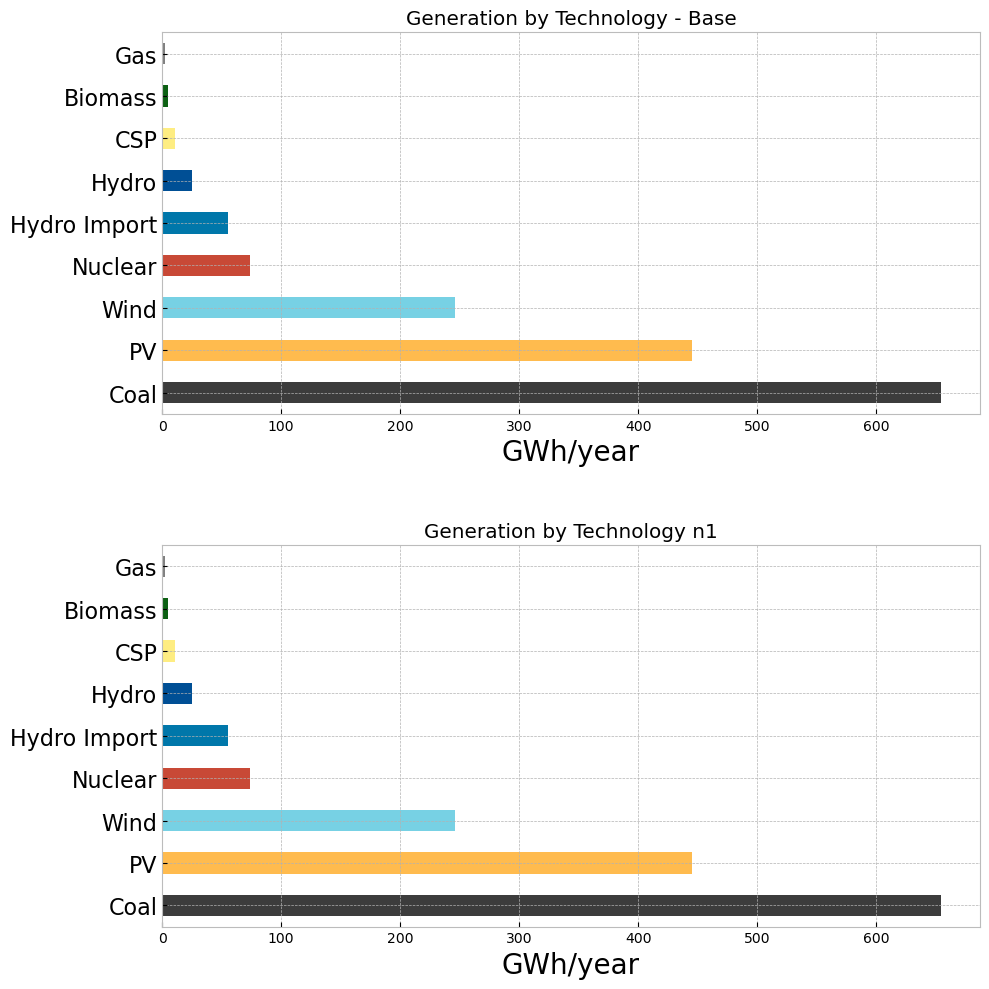

In [26]:

def plot_network_generation(network, ax, title):
    # Group by carrier and sum p_nom, divide by 1000 to convert to GW
    a = network.generators_t.p.sum().groupby(network.generators.carrier).sum().div(1e3)
    
    # Add ocgt and ccgt to gas and remove ocgt and ccgt
    a['gas'] = a.get('gas', 0) + a.get('OCGT', 0) + a.get('CCGT', 0)
    a = a.drop(['OCGT', 'CCGT'], errors='ignore')
    
    a = a[a != 0]

    carrier_order = ['onwind', 'solar', 'CSP', 'hydro', 'hydro-import', 'biomass', 'gas', 'nuclear', 'coal']
    carrier_order_filtered = [carrier for carrier in carrier_order if carrier in a.index]
    a_sorted = a.loc[carrier_order_filtered].sort_values(ascending=False)

    # Create horizontal bar chart on the given ax
    a_sorted.plot.barh(color=[colors.get(carrier, '#333333') for carrier in a_sorted.index], ax=ax)
    ax.set_xlabel('GWh/year', fontsize=20)
    ax.set_title(title)
    ax.set_facecolor('white')
    ax.set_yticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()], fontsize=16)

    ax.set_ylabel('')  # This sets the y-axis label to an empty string

# Create a 2x1 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

plot_network_generation(n0, axes[0], 'Generation by Technology - Base')
plot_network_generation(n1, axes[1], 'Generation by Technology n1')

# Find the global minimum and maximum for the x-axes
min_x = min(ax.get_xlim()[0] for ax in axes.flatten())
max_x = max(ax.get_xlim()[1] for ax in axes.flatten())

# Set the x limits for all the subplots to be the same
for ax in axes.flatten():
    ax.set_xlim(min_x, max_x)

plt.tight_layout(h_pad=4.0)
plt.savefig('combined_plot.png', dpi=600, facecolor='white', bbox_inches='tight')
plt.show()


#### Generated Electricity per Day

In [35]:
# power (MWh) sum of 8760h /24 - MWh per day /1000 - GW per day
p_by_carrier_n0 = n0.generators_t.p.groupby(n0.generators.carrier, axis=1).sum()
p_by_carrier_n0 = p_by_carrier_n0.droplevel(level='period')
p_by_carrier_n0 = p_by_carrier_n0.drop(columns=["load_shedding"])

p_by_carrier_n1 = n1.generators_t.p.groupby(n1.generators.carrier, axis=1).sum()
p_by_carrier_n1 = p_by_carrier_n1.droplevel(level='period')
p_by_carrier_n1 = p_by_carrier_n1.drop(columns=["load_shedding"])

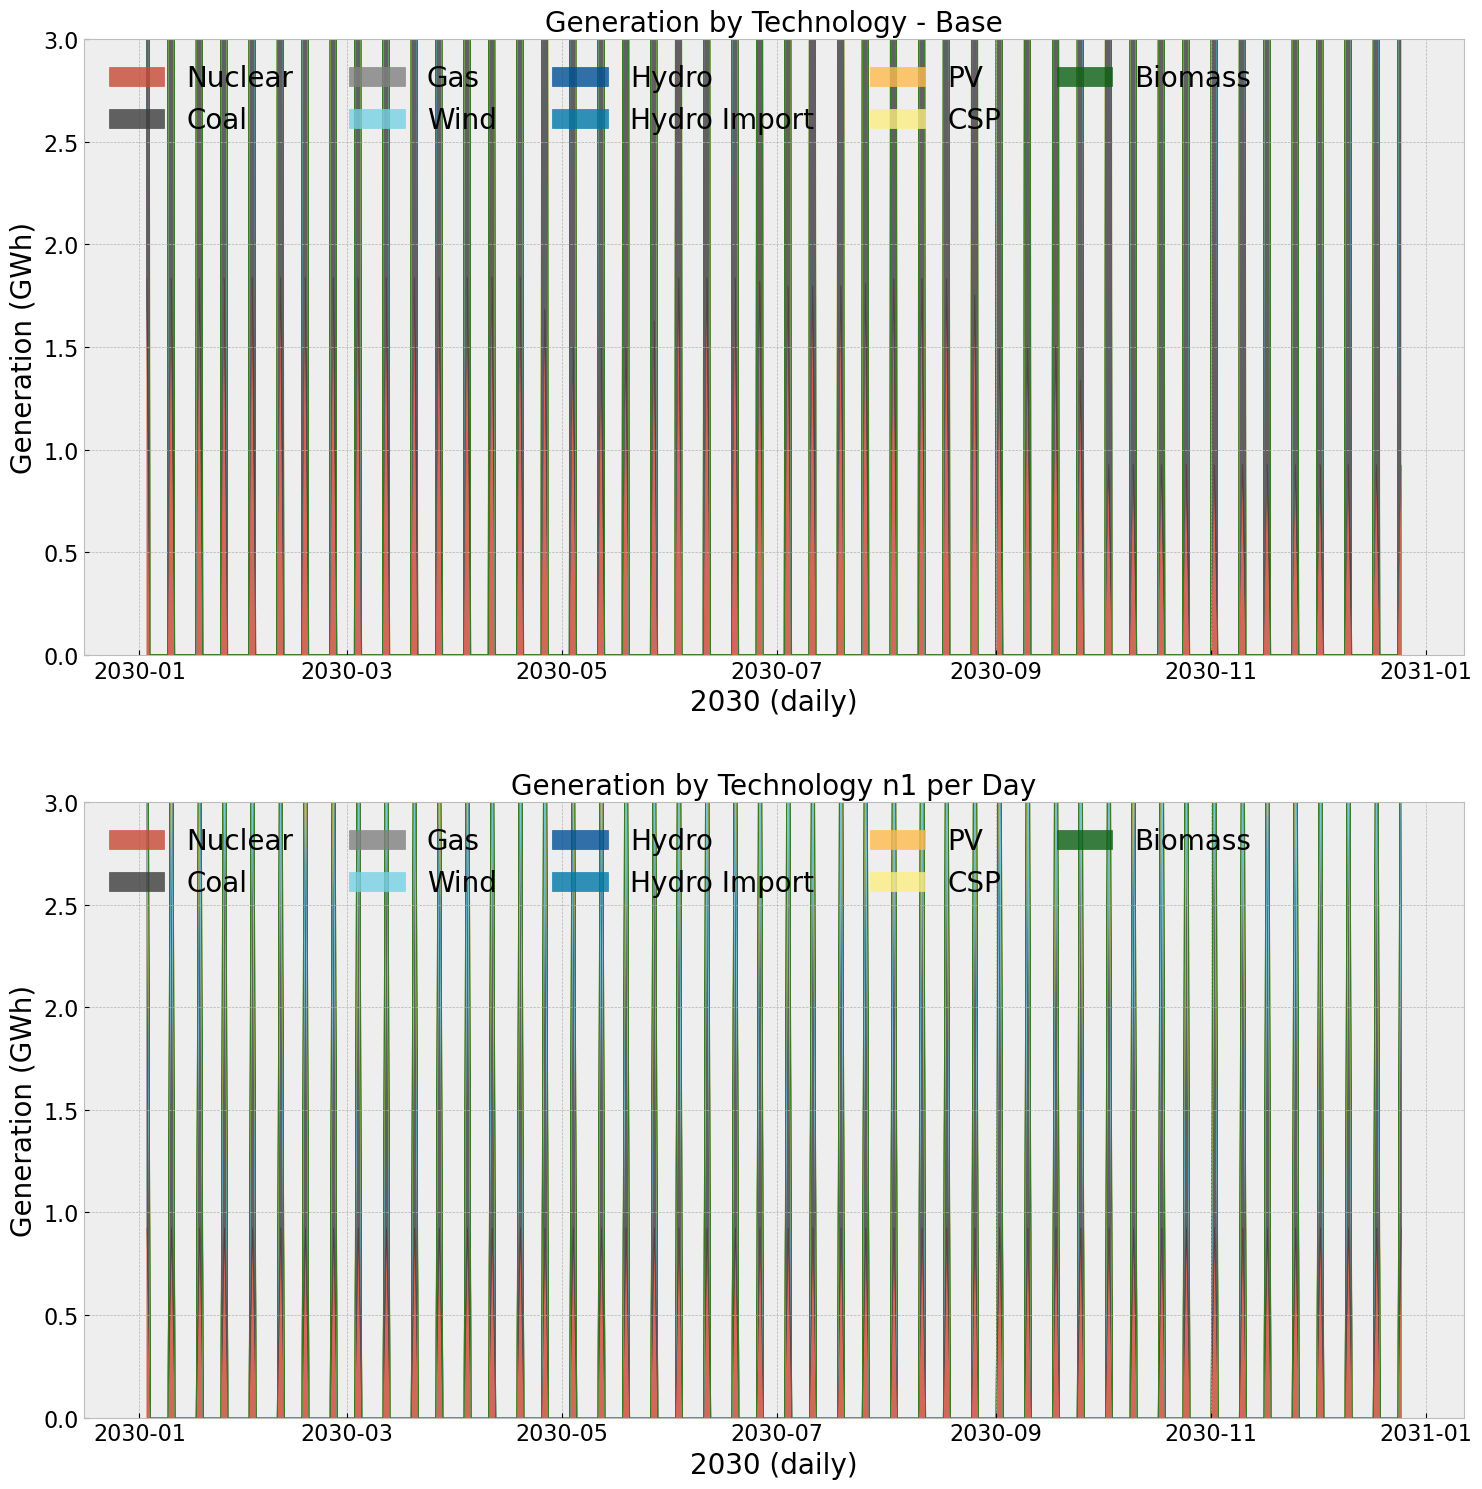

In [45]:

def plot_generation_per_day(p_by_carrier, ax, title):
    # Aggregate OCGT and CCGT into gas and remove them
    if 'OCGT' in p_by_carrier.columns:
        p_by_carrier['gas'] = p_by_carrier.get('gas', 0) + p_by_carrier['OCGT']
        p_by_carrier = p_by_carrier.drop(columns=['OCGT'])

    if 'CCGT' in p_by_carrier.columns:
        p_by_carrier['gas'] += p_by_carrier['CCGT']
        p_by_carrier = p_by_carrier.drop(columns=['CCGT'])
    
    p_by_carrier_resampled = p_by_carrier.resample("D").sum()/1e3
    stacked = p_by_carrier_resampled.stack().reset_index()
    stacked.columns = ['week', 'carrier', 'GW']
    stacked = stacked.pivot(index='week', columns='carrier', values='GW')
    bottom = 0

    for carrier in nice_names:
        if carrier in stacked.columns:
            data = stacked[carrier]
            ax.fill_between(
                data.index, bottom, bottom + data, 
                color=colors[carrier], alpha=0.8, label=nice_names[carrier]
            )
            bottom += data

    ax.legend(ncol=5, loc="upper left", frameon=False, fontsize=20)
    ax.set_xlabel("2030 (daily)", fontsize=20)
    ax.set_ylabel("Generation (GWh)", fontsize=20)
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylim(0,3)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

plot_generation_per_day(p_by_carrier_n0, axes[0], 'Generation by Technology - Base')
plot_generation_per_day(p_by_carrier_n1, axes[1], 'Generation by Technology n1 per Day')

# Set the common x limits if needed
# for ax in axes.flatten():
#     ax.set_xlim(pd.Timestamp('2030-03-29'), pd.Timestamp('2030-03-31'))

plt.tight_layout(h_pad=4.0)
plt.savefig('time_generation_combined.png', dpi=600, facecolor='white', bbox_inches='tight')
plt.show()


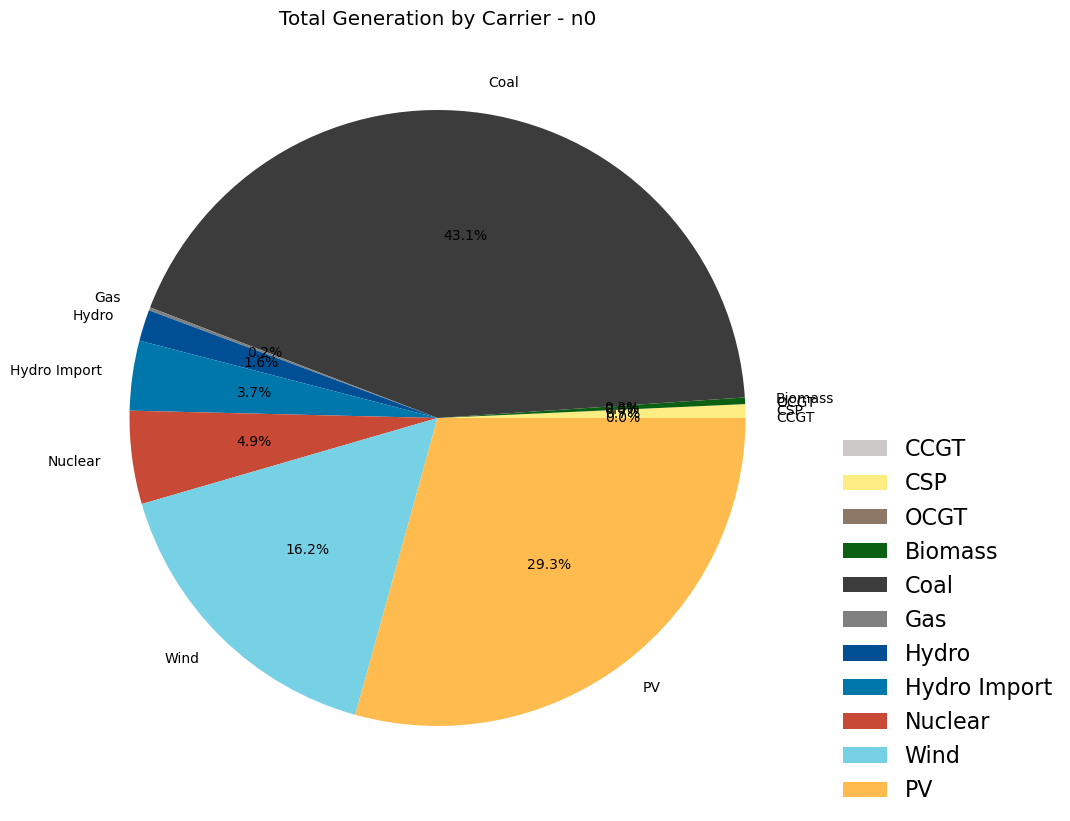

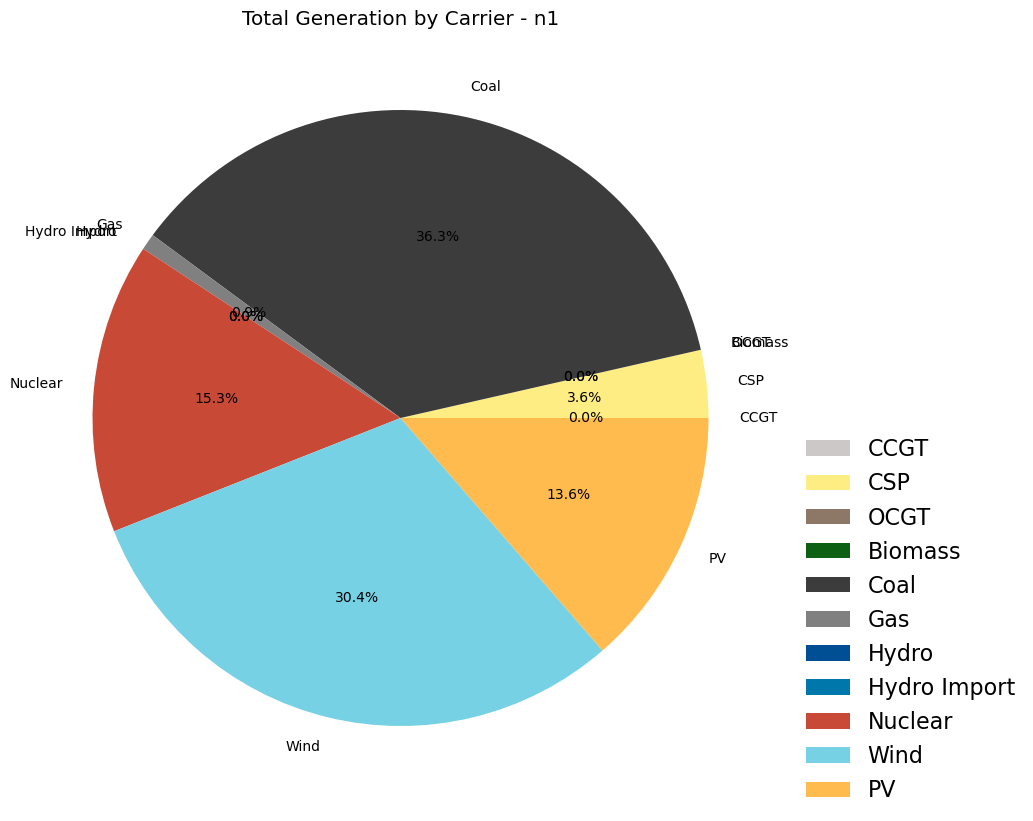

In [43]:
def plot_generation_pie_chart(network, title):
    # Group by carrier and sum p_nom, divide by 1000 to convert to GW
    carriers = network.generators_t.p.sum().groupby(network.generators.carrier).sum().div(1e3)
    
    # Filter carriers to those defined in colors
    carriers = carriers.loc[carriers.index.intersection(colors.keys())]

    # Create a pie chart of the sum of p_nom grouped by carrier
    plt.figure(figsize=(10, 10))
    plt.pie(carriers, labels=[nice_names.get(carrier, carrier) for carrier in carriers.index],
            colors=[colors[carrier] for carrier in carriers.index], radius=1, autopct='%1.1f%%')

    legend_table = []
    for carrier, value in carriers.items():
        legend_table.append([colors[carrier], f"{nice_names.get(carrier, carrier)}"])

    plt.legend(handles=[plt.Rectangle((0, 0), 2, 1, color=color, edgecolor='black', linewidth=1) for carrier, color in colors.items() if carrier in carriers.index],
               labels=[text for carrier, text in legend_table if carrier in carriers.index],
               loc='best', bbox_to_anchor=(1, 0.5), prop={'size': 16}, frameon=False)

    plt.title(title)
    plt.savefig(f'{title.replace(" ", "_").lower()}.png', transparent=True, bbox_inches='tight', dpi=800)
    plt.show()

# Plot for n0
plot_generation_pie_chart(n0, 'Total Generation by Carrier - n0')

# Plot for n1
plot_generation_pie_chart(n1, 'Total Generation by Carrier - n1')

In [37]:
p_by_carrier_n0

carrier,CCGT,CSP,OCGT,biomass,coal,gas,hydro,hydro-import,nuclear,onwind,solar
timestep,,,,,,,,,,,
2030-01-03 04:00:00,0.0,205.130089,0.0,132.906105,11586.332189,52.5,32.429996,1179.770756,1835.460000,4655.500979,10654.436912
2030-01-10 18:00:00,0.0,208.979532,0.0,139.740324,13614.332189,52.5,643.021167,1133.500283,1835.460000,4565.138177,8807.497784
2030-01-18 08:00:00,0.0,304.637497,0.0,137.943687,13765.124442,52.5,661.012238,1136.372282,1835.460000,4339.408359,9868.108286
2030-01-25 22:00:00,0.0,279.448939,0.0,134.163346,13276.169375,52.5,664.631125,1140.183308,1836.450158,4595.593847,9486.119371
2030-02-02 12:00:00,0.0,327.661925,0.0,69.632486,14149.691144,52.5,664.856000,1084.478623,1840.465800,4548.358368,9112.658524
2030-02-10 02:00:00,0.0,181.167884,0.0,52.161745,13217.709620,52.5,664.856000,1108.876879,1840.465800,4154.417053,10729.707277
2030-02-17 16:00:00,0.0,305.550144,0.0,89.955719,13736.393486,52.5,659.560762,1126.740379,1840.465800,4753.947972,8979.037546
2030-02-25 06:00:00,0.0,318.382715,0.0,87.230189,12805.579954,52.5,636.269665,1110.925169,1839.622332,4029.595454,10472.163782
2030-03-04 20:00:00,0.0,331.537708,0.0,116.663424,13202.641228,52.5,624.089024,697.664938,1838.797200,4786.324774,9780.200433


In [38]:
p_by_carrier_n1

carrier,CCGT,CSP,OCGT,biomass,coal,gas,hydro,hydro-import,nuclear,onwind,solar
timestep,,,,,,,,,,,
2030-01-03 04:00:00,0.0,194.873585,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1495.190349,966.219768
2030-01-10 18:00:00,0.0,198.530556,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1758.202171,788.903336
2030-01-18 08:00:00,0.0,289.405624,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1503.596903,845.790247
2030-01-25 22:00:00,0.0,265.476492,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1644.183594,820.528525
2030-02-02 12:00:00,0.0,311.278829,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1636.508014,750.463515
2030-02-10 02:00:00,0.0,172.109489,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1449.186469,932.884223
2030-02-17 16:00:00,0.0,290.272637,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1611.551731,737.200875
2030-02-25 06:00:00,0.0,302.463577,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1492.722304,945.397055
2030-03-04 20:00:00,0.0,314.960821,0.0,0.0,2208.0,52.5,0.0,0.0,927.0,1768.917618,873.277337


# 4.Storage Unit

In [39]:
def get_storage_data(network):
    storage_p_sum = network.storage_units_t.p.sum()
    storage_p_sum = storage_p_sum.loc[storage_p_sum != 0]
    
    storage_p_nom_opt = network.storage_units.p_nom_opt
    storage_p_nom_opt = storage_p_nom_opt.loc[storage_p_nom_opt != 0]

    return storage_p_sum, storage_p_nom_opt

# Get the data for each network
a0, b0 = get_storage_data(n0)
a1, b1 = get_storage_data(n1)

# Combine storage_p_sum data
storage_p_sum_combined = pd.concat([a0, a1], axis=1, keys=['n0', 'n1'])
print("Storage p sum:")
print(storage_p_sum_combined)

print("\nSums of storage p sum:")
print(storage_p_sum_combined.sum())

storage_p_nom_opt_combined = pd.concat([b0, b1], axis=1, keys=['n0', 'n1'])
print("\nStorage p_nom_opt:")
print(storage_p_nom_opt_combined)

print("\nSums of storage p_nom_opt:")
print(storage_p_nom_opt_combined.sum())

# CSV
combined_csv = pd.concat([storage_p_sum_combined, storage_p_nom_opt_combined], keys=['storage_p_sum', 'storage_p_nom_opt'])
combined_csv.to_csv('storage.csv')




Storage p sum:
                     n0  n1
StorageUnit                
Drakensberg -171.358544 NaN
Ingula      -340.999273 NaN
Palmiet      -48.552767 NaN

Sums of storage p sum:
n0   -560.910584
n1      0.000000
dtype: float64

Storage p_nom_opt:
                 n0      n1
StorageUnit                
Drakensberg  1000.0  1000.0
Ingula       1332.0  1332.0
Palmiet       400.0   400.0
Steenbras     180.0   180.0

Sums of storage p_nom_opt:
n0    2912.0
n1    2912.0
dtype: float64


# 6. Total Annual System Costs

In [40]:
objectives = {
    'n0': n0.objective / 1e9,
    'n1': n1.objective / 1e9
}

# Converting the dictionary into a DataFrame
objectives_df = pd.DataFrame(list(objectives.items()), columns=['Network', 'Objective'])

# Print or display the DataFrame
print(objectives_df)

# If you want to save it to a CSV file
objectives_df.to_csv('total_costs.csv', index=False)


  Network   Objective
0      n0  209.553491
1      n1  134.529930


In [28]:
n0.carriers.filter(like="_emissions")


,co2_emissions
Carrier,
CSP,0.0000
biomass,0.0000
PHS,0.0000
coal,0.3000
gas,0.1794
hydro,0.0000
hydro-import,0.0000
nuclear,0.0000
CCGT,0.1794


In [20]:
emission_prices = {
    'co2': 530.19,  # 30 USD/tCO2 * 17.673 ZAR/USD
    'sox': 0.0,
    'nox': 0.0,
    'hg': 0.0,
    'particulate': 0.0
}

In [29]:
def add_emission_prices(n, emission_prices={"co2": 530.19}, exclude_co2=False):
    if exclude_co2:
        emission_prices.pop("co2")
    ep = (
        pd.Series(emission_prices).rename(lambda x: x + "_emissions")
        * n.carriers.filter(like="_emissions")
    ).sum(axis=1)

    gen_ep = n.generators.carrier.map(ep) / n.generators.efficiency
    n.generators["marginal_cost"] += gen_ep
    su_ep = n.storage_units.carrier.map(ep) / n.storage_units.efficiency_dispatch
    n.storage_units["marginal_cost"] += su_ep

In [30]:
def add_emission_prices2(n, emission_prices={"co2": 530.19}, exclude_co2=False):
    if exclude_co2:
        emission_prices.pop("co2")
    ep = (
        pd.Series(emission_prices).rename(lambda x: x + "_emissions")
        * n.carriers.filter(like="_emissions")
    ).sum(axis=1)

    gen_ep = n.generators.carrier.map(ep) / n.generators.efficiency
    n.generators["marginal_cost"] -= gen_ep
    su_ep = n.storage_units.carrier.map(ep) / n.storage_units.efficiency_dispatch
    n.storage_units["marginal_cost"] -= su_ep

In [32]:
import copy

# 1. Clone your networks (deepcopy to ensure no shared references)
n0e = copy.deepcopy(n0)
n1e= copy.deepcopy(n1)
n2e = copy.deepcopy(n2)
n3e = copy.deepcopy(n3)

# 2. Apply emission prices to cloned networks
add_emission_prices(n0e)
add_emission_prices(n1e)
add_emission_prices(n2e)
add_emission_prices2(n3e)


In [33]:
def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
    components = dict(
        Link=("p_nom", "p0"),
        Generator=("p_nom", "p"),
        StorageUnit=("p_nom", "p"),
        Store=("e_nom", "p"),
        Line=("s_nom", None),
        Transformer=("s_nom", None),
    )

    costs = {}
    for c, (p_nom, p_attr) in zip(
        n.iterate_components(components.keys(), skip_empty=False), components.values()
    ):
        if c.df.empty:
            continue
        if not existing_only:
            p_nom += "_opt"
        costs[(c.list_name, "capital")] = (
            (c.df[p_nom] * c.df.capital_cost).groupby(c.df.carrier).sum()
        )
        if p_attr is not None:
            p = c.pnl[p_attr].sum()
            if c.name == "StorageUnit":
                p = p.loc[p > 0]
            costs[(c.list_name, "marginal")] = (
                (p * c.df.marginal_cost).groupby(c.df.carrier).sum()
            )
    costs = pd.concat(costs)

    if flatten:
        assert opts is not None
        conv_techs = opts["conv_techs"]

        costs = costs.reset_index(level=0, drop=True)
        costs = costs["capital"].add(
            costs["marginal"].rename({t: t + " marginal" for t in conv_techs}),
            fill_value=0.0,
        )

    return costs

In [34]:
costs_df0 = aggregate_costs(n0, flatten=False, opts=None, existing_only=False)
costs_df1 = aggregate_costs(n1, flatten=False, opts=None, existing_only=False)
costs_df2 = aggregate_costs(n2, flatten=False, opts=None, existing_only=False)
costs_df3 = aggregate_costs(n3, flatten=False, opts=None, existing_only=False)

costs_df0e = aggregate_costs(n0e, flatten=False, opts=None, existing_only=False)
costs_df1e = aggregate_costs(n1e, flatten=False, opts=None, existing_only=False)
costs_df2e = aggregate_costs(n2e, flatten=False, opts=None, existing_only=False)
costs_df3e = aggregate_costs(n3e, flatten=False, opts=None, existing_only=False)

# Combine all the cost DataFrames into a single DataFrame
combined_costs = pd.concat([costs_df0, costs_df1, costs_df2, costs_df3], axis=1, keys=['n0', 'n1', 'n2', 'n3'])

combined_costs_in_millions = combined_costs / 1e6  # Convert to millions

# Convert the costs to USD using the exchange rate
combined_costs_in_usd = combined_costs_in_millions / 17.673

# Round the values to two decimal places
combined_costs_in_usd = combined_costs_in_usd.round(2)

# Print or display the formatted combined DataFrame in USD
print(combined_costs_in_usd)

# Save the formatted DataFrame to a CSV file
combined_costs_in_usd.to_csv('combined_costs_in_usd.csv')

                                           n0       n1       n2       n3
                       carrier                                          
generators    capital  CCGT              0.00     0.00     0.00    53.00
                       CSP             356.46   356.46   356.46   356.46
                       OCGT            798.07   740.93   675.37   344.02
                       biomass         109.11   109.11   109.11   109.11
                       coal           2533.85  2533.85  2533.85  2533.85
                       gas              36.38    36.38    36.38    36.38
                       hydro             0.00     0.00     0.00     0.00
                       hydro-import      0.00     0.00     0.00     0.00
                       load_shedding     0.00     0.00     0.00     0.00
                       nuclear         124.52   124.52   124.52   124.52
                       onwind          900.61  2296.70  3398.45  5544.64
                       solar           651.90   893

In [35]:
# Aggregation of costs for each scenario
costs_df0 = aggregate_costs(n0, flatten=False, opts=None, existing_only=False)
costs_df1 = aggregate_costs(n1, flatten=False, opts=None, existing_only=False)
costs_df2 = aggregate_costs(n2, flatten=False, opts=None, existing_only=False)
costs_df3 = aggregate_costs(n3, flatten=False, opts=None, existing_only=False)

costs_df0e = aggregate_costs(n0e, flatten=False, opts=None, existing_only=False)
costs_df1e = aggregate_costs(n1e, flatten=False, opts=None, existing_only=False)
costs_df2e = aggregate_costs(n2e, flatten=False, opts=None, existing_only=False)
costs_df3e = aggregate_costs(n3e, flatten=False, opts=None, existing_only=False)

# Combine all the cost DataFrames into a single DataFrame
combined_costs = pd.concat([
    costs_df0, costs_df1, costs_df2, costs_df3e,
    costs_df0e, costs_df1e, costs_df2e, costs_df3
], axis=1, keys=['n0', 'n1', 'n2', 'n3e', 'n0e', 'n1e', 'n2e', 'n3'])

combined_costs_in_millions = combined_costs / 1e6  # Convert to millions

# Convert the costs to USD using the exchange rate of 17.673
combined_costs_in_usd = combined_costs_in_millions / 17.673

# Round the values to two decimal places
combined_costs_in_usd = combined_costs_in_usd.round(2)

# Print or display the formatted combined DataFrame in USD
print(combined_costs_in_usd)

# Save the formatted DataFrame to a CSV file
combined_costs_in_usd.to_csv('combined_costs_in_usd_with_e.csv')


                                           n0       n1       n2      n3e  \
                       carrier                                             
generators    capital  CCGT              0.00     0.00     0.00    53.00   
                       CSP             356.46   356.46   356.46   356.46   
                       OCGT            798.07   740.93   675.37   344.02   
                       biomass         109.11   109.11   109.11   109.11   
                       coal           2533.85  2533.85  2533.85  2533.85   
                       gas              36.38    36.38    36.38    36.38   
                       hydro             0.00     0.00     0.00     0.00   
                       hydro-import      0.00     0.00     0.00     0.00   
                       load_shedding     0.00     0.00     0.00     0.00   
                       nuclear         124.52   124.52   124.52   124.52   
                       onwind          900.61  2296.70  3398.45  5544.64   
            

In [29]:
# Calculate the total costs for each scenario
total_cost0 = costs_df0.sum().sum()
total_cost1 = costs_df1.sum().sum()


total_cost0e = costs_df0e.sum().sum()
total_cost1e = costs_df1e.sum().sum()


# Print the total costs
print("Total costs for standard scenarios:")
print(total_cost0)
print(total_cost1)


print("\nTotal costs for 'e' scenarios:")
print(total_cost0e)
print(total_cost1e)




NameError: name 'costs_df0' is not defined

# 7. Marginal Price

In [18]:
bus_type_n0 = pd.Series(n0.buses.index.str[0:], n0.buses.index).replace("", "electricity")
prices_n0 = n0.buses_t.marginal_price.mean().groupby(bus_type_n0).mean()
average_price_n0 = prices_n0.mean()

bus_type_n1 = pd.Series(n1.buses.index.str[0:], n1.buses.index).replace("", "electricity")
prices_n1 = n1.buses_t.marginal_price.mean().groupby(bus_type_n1).mean()
average_price_n1 = prices_n1.mean()

bus_type_n2 = pd.Series(n3.buses.index.str[0:], n3.buses.index).replace("", "electricity")
prices_n2 = n3.buses_t.marginal_price.mean().groupby(bus_type_n2).mean()
average_price_n2 = prices_n2.mean()

bus_type_n3 = pd.Series(n3.buses.index.str[0:], n3.buses.index).replace("", "electricity")
prices_n3 = n3.buses_t.marginal_price.mean().groupby(bus_type_n3).mean()
average_price_n3 = prices_n3.mean()

print(f"Average Marginal Price for n0: {average_price_n0:.2f}  ZAR/MWh")
print(f"Average Marginal Price for n1: {average_price_n1:.2f}  ZAR/MWh")
print(f"Average Marginal Price for n2: {average_price_n2:.2f}  ZAR/MWh")
print(f"Average Marginal Price for n3: {average_price_n3:.2f}  ZAR/MWh")


Average Marginal Price for n0: 543.73  ZAR/MWh
Average Marginal Price for n1: 431.06  ZAR/MWh
Average Marginal Price for n2: 718.34  ZAR/MWh
Average Marginal Price for n3: 718.34  ZAR/MWh


In [19]:
total_electricity_n3 = n3.generators_t.p.sum().sum() /1e3 #MWh

# in Mt -> USD 30/tCO2 * 17.637 * 1000
emissioncost3 = 23.114941 *30 *17.637 * 1000

#emissions costs / total generated electricity in MWh
tax_cost = emissioncost3 / total_electricity_n3

average_price_without_tax_n3 = average_price_n3 - tax_cost
print(f"Average Marginal Price for n3 without CO2 tax: {average_price_without_tax_n3:.2f} ZAR/MWh")


Average Marginal Price for n3 without CO2 tax: 674.55 ZAR/MWh


In [20]:
# Given CO2 tax in USD/tCO2
CO2_tax = 30*17.637

# Function to calculate the price with tax
def price_with_tax(network, average_price, emissions_in_mt):
    total_electricity = network.generators_t.p.sum().sum() / 1e3 # MWh
    emission_cost = emissions_in_mt * CO2_tax * 1000 # in USD
    tax_cost = emission_cost / total_electricity
    return average_price + tax_cost

# Emissions for each network in Mt
emissions = {
    'n0': 152.005776,
    'n1': 105.508525,
    'n2': 65.172835,
    'n3': 23.114941

}

average_prices = {
    'n0': average_price_n0,
    'n1': average_price_n1,
    'n2': average_price_n2,
    'n3': average_price_n3,

}

prices_with_tax = {}
for net, avg_price in average_prices.items():
    prices_with_tax[net] = price_with_tax(eval(net), avg_price, emissions[net])

for net, price in prices_with_tax.items():
    print(f"Average Marginal Price for {net} with CO2 tax: {price:.2f} ZAR/MWh")


Average Marginal Price for n0 with CO2 tax: 832.89 ZAR/MWh
Average Marginal Price for n1 with CO2 tax: 631.62 ZAR/MWh
Average Marginal Price for n2 with CO2 tax: 842.08 ZAR/MWh
Average Marginal Price for n3 with CO2 tax: 762.14 ZAR/MWh


In [ ]:
# Your existing data dictionary:
data = {
    "Network": ["n0", "n1", "n2", "n3"],
    "Average Marginal Price Without CO2 Tax (ZAR/MWh)": [
        average_price_n0,
        average_price_n1,
        average_price_n2,
        average_price_without_tax_n3
    ]
}

# Add the average prices with tax to the data dictionary:
data["Average Marginal Price With CO2 Tax (ZAR/MWh)"] = [
    prices_with_tax.get("n0", average_price_n0),
    prices_with_tax.get("n1", average_price_n1),
    prices_with_tax.get("n2", average_price_n2),
    prices_with_tax.get("n3", average_price_n3)
]

# Convert the dictionary to a DataFrame:
df = pd.DataFrame(data)

# Save the DataFrame to a CSV:
df.to_csv("average_marginal_prices.csv", index=False)

print("Results saved in 'average_marginal_prices.csv'")


In [ ]:
df_n0 = n0.buses_t.marginal_price.reset_index()
df_n1 = n1.buses_t.marginal_price.reset_index()
df_n2 = n2.buses_t.marginal_price.reset_index()
df_n3 = n3.buses_t.marginal_price.reset_index()

# Convert the 'timestep' column to datetime type for all DataFrames
for df in [df_n0, df_n1, df_n2, df_n3]:
    df['timestep'] = pd.to_datetime(df['timestep'])

# Set 'timestep' as the index for all DataFrames
for df in [df_n0, df_n1, df_n2, df_n3]:
    df.set_index('timestep', inplace=True)

# Resample the data for daily averages for all DataFrames
df_daily_n0 = df_n0.resample('D').mean()
df_daily_n1 = df_n1.resample('D').mean()
df_daily_n2 = df_n2.resample('D').mean()
df_daily_n3 = df_n3.resample('D').mean()

# Plotting the data in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
dataframes = [df_daily_n0, df_daily_n1, df_daily_n2, df_daily_n3]
titles = ['n0', 'n1', 'n2', 'n3']

for ax, df, title in zip(axs.flat, dataframes, titles):
    df.plot(kind='line', ax=ax, legend=True, linewidth=0.5)
    ax.set_ylabel('Marginal Price in ZAR/MWh')
    ax.set_xlabel('Time')
    ax.set_title(f'Marginal Price - Network {title}')

plt.tight_layout()
plt.savefig('marginal_price_2x2.png', dpi=600, facecolor='white', bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_boundaries = [14, 34, -35, -22] 

# Create a custom colormap similar to the line capacity plot
custom_cmap = LinearSegmentedColormap.from_list(
    'custom', [(0, 'blue'), (0.5, 'yellow'), (1, 'red')])

fig, axs = plt.subplots(2, 2, figsize=(14, 14), subplot_kw={'projection': ccrs.PlateCarree()})
networks = [n0, n1, n2, n3]
labels = ['n0', 'n1', 'n2', 'n3']

# Get global min and max marginal prices across all networks for consistent coloring
all_marginal_prices = [network.buses_t.marginal_price.mean() for network in networks]
global_min = min(price.min() for price in all_marginal_prices)
global_max = max(price.max() for price in all_marginal_prices)
scatter_norm = plt.Normalize(vmin=global_min, vmax=global_max)

for ax, network, label in zip(axs.flat, networks, labels):
    
    # Plot geographical features with the same appearance as in the line loading plot
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black', color='white')  # Using a light grey for land, adjust as needed
    
    # Plotting buses with marginal prices using the custom colormap
    marginal_prices = network.buses_t.marginal_price.mean()
    sc = ax.scatter(network.buses['x'], network.buses['y'], c=marginal_prices, s=50, cmap=custom_cmap, edgecolors='k', linewidth=0.5, transform=ccrs.PlateCarree(), norm=scatter_norm)
    
    ax.set_title(f"Network {label}")
    ax.set_xlim(map_boundaries[0], map_boundaries[1])
    ax.set_ylim(map_boundaries[2], map_boundaries[3])
    ax.grid(True)
    
    # Colorbar for marginal prices using the custom colormap
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, shrink=0.6)
    cbar.set_label('Average Marginal Price [ZAR/MWh]')

plt.tight_layout()
plt.savefig("map_marginal_prices.png")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs

map_boundaries = [14, 34, -35, -22] 

fig, axs = plt.subplots(2, 2, figsize=(14, 14), subplot_kw={'projection': ccrs.PlateCarree()})
networks = [n0, n1, n2, n3]
labels = ['n0', 'n1', 'n2', 'n3']

for ax, network, label in zip(axs.flat, networks, labels):
    
    # Plotting buses with marginal prices
    marginal_prices = network.buses_t.marginal_price.mean()
    scatter_norm = plt.Normalize(vmin=marginal_prices.min(), vmax=marginal_prices.max())
    sc = ax.scatter(network.buses['x'], network.buses['y'], c=marginal_prices, s=50, cmap='viridis', edgecolors='k', linewidth=0.5, transform=ccrs.PlateCarree(), norm=scatter_norm)
    
    ax.set_title(f"Network {label}")
    ax.set_xlim(map_boundaries[0], map_boundaries[1])
    ax.set_ylim(map_boundaries[2], map_boundaries[3])
    ax.grid(True)
    
    # Colorbar for marginal prices
    cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, shrink=0.6)
    cbar.set_label('Average Marginal Price [ZAR/MWh]')

plt.tight_layout()
plt.savefig("networks_marginal_prices.png")
plt.show()


# 8. CO2 Emissions

In [ ]:
#### Total CO2 emissions by the network (efficiency and fuel source)

In [28]:
networks = [n0, n1, n2, n3]

# empty DataFrame to store the results
all_emissions = pd.DataFrame()

# Loop through the networks and calculate the emissions
for idx, network in enumerate(networks):
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    e = (emissions/network.generators.efficiency*network.generators.carrier.map(network.carriers.co2_emissions)).sum()
    e_carrier = e.groupby(network.generators.carrier).sum()/1e6
    e_carrier.rename(index={'OCGT': 'gas'}, inplace=True)
    e_carrier.rename(index={'CCGT': 'gas'}, inplace=True)
    e_carrier = e_carrier.groupby('carrier').sum()
    e_carrier = e_carrier.loc[lambda x: x != 0]
    
    all_emissions[f'n{idx}'] = e_carrier

# Compute the sum of emissions for each network and append it as a new row
all_emissions.loc['sum'] = all_emissions.sum()

# Print the result
print(all_emissions)


                 n0          n1         n2         n3
carrier                                              
coal     151.668654  105.367042  65.061273  22.789235
gas        0.337122    0.141483   0.111563   0.325653
sum      152.005776  105.508525  65.172835  23.114888


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
fig.suptitle('Emissions per Carrier for Different Networks')

networks = [n0, n1, n2, n3]

max_y = 0

# First, find the maximum y-value to set the same y-limit for all subplots
for network in networks:
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    e = (emissions/network.generators.efficiency*network.generators.carrier.map(network.carriers.co2_emissions)).sum()
    e_carrier = e.groupby(network.generators.carrier).sum()/1e6
    e_carrier.rename(index={'OCGT': 'gas'}, inplace=True)
    e_carrier = e_carrier.groupby('carrier').sum()
    e_carrier = e_carrier.loc[lambda x: x != 0]
    max_y = max(max_y, e_carrier.max()*1.1)

for idx, network in enumerate(networks):
    row = idx // 2
    col = idx % 2

    ax = axes[row, col]

    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    e = (emissions/network.generators.efficiency*network.generators.carrier.map(network.carriers.co2_emissions)).sum()
    e_carrier = e.groupby(network.generators.carrier).sum()/1e6
    e_carrier.rename(index={'OCGT': 'gas'}, inplace=True)
    e_carrier.rename(index={'CCGT': 'gas'}, inplace=True)
    e_carrier = e_carrier.groupby('carrier').sum()
    e_carrier = e_carrier.loc[lambda x: x != 0]

    e_carrier.plot(kind="bar", ax=ax, rot=0, color=["black", "grey"])
    ax.set_xlabel("Carrier")
    ax.set_ylabel("Emissions [tCO2/year]")
    ax.set_title(f"Emissions for n{idx}")
    ax.set_ylim(0, max_y) # set the same y-limit for all subplots

    ax.set_xticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()], fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make sure the titles fit well
plt.savefig("emissions_per_carrier_combined.png")
plt.show()


In [ ]:
#### Plot total CO2 emissions per day

In [ ]:
# List of networks
networks = [n0, n1, n2, n3]

# Create a subplot with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(11, 10), sharey=True)
axes = axes.flatten()  # Flatten the 2x2 grid to access the axes easily

for idx, network in enumerate(networks):
    # Calculate emissions
    emissions = (network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)).sum(axis=1)
    emissions = emissions.droplevel(level='period')
    emissions = emissions.resample("D").sum()/1e3
    
    # Plot emissions for this network
    emissions.plot(ax=axes[idx], title=f'Change in CO2 Emissions over Time for n{idx}',
                   xlabel='Time (daily)', ylabel='CO2 Emissions in Mt')

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig("emissions_all_networks.png")

# Show plot
plt.show()
